<a href="https://colab.research.google.com/github/seonleeuni/mge51101-20205196/blob/master/Linear_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi
import numpy as np
import torch
import tensorflow as tf
print("numpy version:{}/ torch version:{}/ tf version{}".format(np.__version__, tf.__version__, torch.__version__))

Sat Apr  4 14:40:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     6W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import time
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # Start the timer
        self.tik = time.time()

    def stop(self):
        # Stop the timer and record the time in a list
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        # Return the average time
        return sum(self.times) / len(self.times)

    def sum(self):
        # Return the sum of time
        return sum(self.times)

    def cumsum(self):
        # Return the accumulated times
        return np.array(self.times).cumsum().tolist()

In [0]:
n = 1000
a = np.ones(n)
b = np.ones(n)
c = np.zeros(n)

timer = Timer()
for i in range(n):
  c[i] = a[i] +b[i]
print("{:.5f} sec".format(timer.stop()))

timer.start()
d = a+b
print("{:.5f} sec".format(timer.stop()))
print("d is {:.0f}x faster than c".format(timer.times[0]/timer.times[1]))

0.00050 sec
0.00010 sec
d is 5x faster than c


## Data preparation (Linear regression)

In [0]:
def synthetic_data(w, b, num_examples):
  X = np.random.normal(0,1, (num_examples, len(w)))
  y = np.dot(X,w) + b
  y += np.random.normal(0, 0.01, y.shape)
  return X, y

true_w = np.array([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, n) #Training data

In [0]:
print(features.shape,labels.shape)

(1000, 2) (1000,)


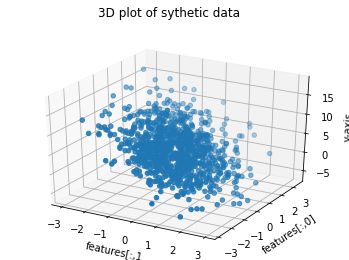

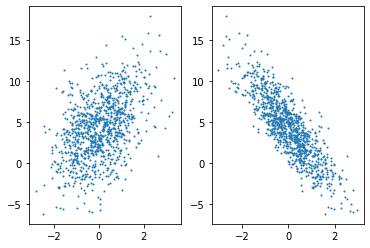

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(); ax = fig.gca(projection = '3d')
ax.scatter(features[:,1], features[:,0],labels)
ax.set_xlabel("features[:,1")
ax.set_ylabel("features[:,0]")
ax.set_zlabel("y-axis")

plt.suptitle("3D plot of sythetic data")
plt.show()

plt.subplot(1,2,1)
plt.scatter(features[:,0],labels,1)
plt.subplot(1,2,2)
plt.scatter(features[:,1],labels,1)
plt.show()

## Linear Neaural Network

In [0]:
import torch
import torch.nn as nn

In [0]:
X, y = torch.from_numpy(features).float(), torch.from_numpy(labels).float().reshape(-1, 1) ##Resahpe (-1)은 원래거 그대로 가져와라는 말 근데 (-1,-1)은 안됨
print(X.shape, y.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


reason to change to torch --> gradient!

In [0]:
from torch.utils.data import TensorDataset, DataLoader

def load_array(data_arrays, batch_size, is_train = True):
  dataset = TensorDataset(*data_arrays)
  dataloader = DataLoader(dataset = dataset, 
                          batch_size = batch_size, 
                          shuffle = is_train)
  return dataloader

The role of DataLoader = To save memory and time

In [0]:
#Batch 뽑기
batch_size = 10
data_iter = load_array((X,y), batch_size)

for X, y in data_iter:
  print(X)
  print(y)
  break

tensor([[-0.6409, -0.5950],
        [ 0.0058, -0.7280],
        [-0.2947,  0.1731],
        [-1.4776,  0.2902],
        [ 2.0979, -0.3804],
        [-0.2972, -0.9812],
        [-0.3814,  1.4758],
        [ 1.3563,  0.3463],
        [-1.0662,  0.4664],
        [ 0.2986,  0.0467]])
tensor([[ 4.9542],
        [ 6.6993],
        [ 3.0205],
        [ 0.2760],
        [ 9.6572],
        [ 6.9470],
        [-1.5717],
        [ 5.7402],
        [ 0.4695],
        [ 4.6337]])


### Every model setting rule
''' python
  class model name(torch.nn.Module):
    def __init__(self):
      super(model name,self).__init__()
      self.layer = torch.nn.-- #single layer
'''


In [0]:

class LinearRegressionModel(torch.nn.Module):
  def __init__(self):
    super(LinearRegressionModel,self).__init__() # 이부분을 모르겠듬
    self.layer = torch.nn.Linear(2, 1, bias = True) #construct layer, bias = True : bias(b) 포함
    # 위에서 지정한 parameter(weignt) 의 크기(2,1) 일단 지금은 true parameter 을 몰라서 앞으로 알아낼거니까 initially 지정

  def forward(self, inputs):
    outputs = self.layer(inputs)
    return outputs

model = LinearRegressionModel()

In [0]:
# 처음엔 randomly 하게 지정이 되는거임! input을 안줬으니깐
print(model.layer.weight.data)
print(model.layer.bias.data)

tensor([[-0.1385, -0.3186]])
tensor([-0.5826])


In [0]:
#criterian & optimizer 가 뭐지? (criterion = sum of MSEloss, optimizer = ???)
#다양한 optimizer 가 있던데...? 그게 뭐지?
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = 0.03) #lr : running weight?
#model 지정할때는 running weight and batch size 지정해줘야됨

epoch:1, loss:66.48167419433594
epoch:2, loss:17.49738311767578
epoch:3, loss:6.336850643157959
epoch:4, loss:2.902343273162842
epoch:5, loss:1.4843333959579468
epoch:6, loss:0.7905948758125305
epoch:7, loss:0.4269852638244629
epoch:8, loss:0.23184067010879517
epoch:9, loss:0.12630298733711243
epoch:10, loss:0.06908836215734482


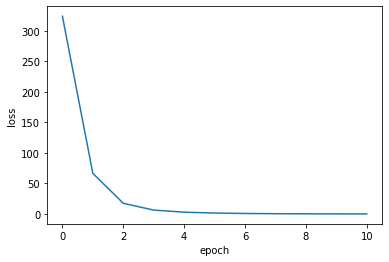

In [0]:
num_epochs = 10 #how many times you read for training(reading whole data(mini batch))
loss_graph = []
loss_graph.append(criterion(model(X),y))
#training code~
for epoch in range(num_epochs): 
  for X, y in data_iter: #data_iter --> batchs (from dataloader function)
    predict = model(X)
    loss = criterion(predict, y)
    optimizer.zero_grad() # set gradient 0: gradient초기화 과정
    loss.backward() #lossfunction 을 backward 해서 gradient automatically 구해주나본데
    optimizer.step()
    #~/
  loss_epoch = criterion(model(X), y)
  loss_graph.append(loss_epoch)
  print("epoch:{}, loss:{}".format(epoch+1, loss_epoch))
plt.plot(loss_graph);
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
# true_w = np.array([2, -3.4])
# true_b = 4.2

weight = model.layer.weight.detach().numpy()
bias = model.layer.bias.detach().numpy()

print("estimated_w = {}".format(weight))
print("estimated_b = {}".format(bias))

estimated_w = [[ 2.015127  -3.2793324]]
estimated_b = [4.1994524]


In [0]:
# y_hat 구하기(평면 그리기용) , X1, X2 --> range of graph
X1 = np.arange(-3, 3, 0.25)
X2 = np.arange(-3, 3, 0.25)
X1, X2 = np.meshgrid(X1, X2)

def predict_surface(input_data, weight, bias):
  weight = weight.reshape(2, 1)
  y_hat = np.dot(input_data.transpose(1, 0).reshape(-1,2), weight) + bias
  return y_hat

y_hat = predict_surface(X1, weight, bias)
y_hat = np.tile(y_hat, 2).reshape(X1.shape[0],-1)


Text(0.5, 0, 'y-axis')

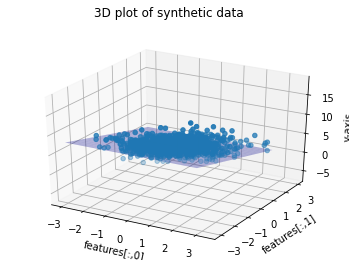

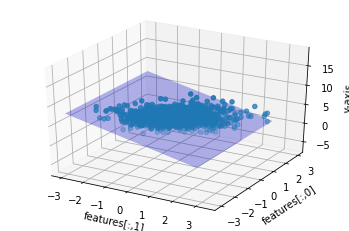

In [0]:
fig = plt.figure(); ax = fig.gca(projection = '3d')
ax.plot_surface(X1, X2, y_hat, color = 'b', alpha = 0.3)
ax.scatter(features[:,0], features[:,1], labels)
ax.set_xlabel("features[:,0]")
ax.set_ylabel("features[:,1]")
ax.set_zlabel("y-axis")

plt.suptitle("3D plot of synthetic data")

fig = plt.figure(); ax = fig.gca(projection = '3d')
ax.plot_surface(X2, X1, y_hat, color = 'b', alpha = 0.3)
ax.scatter(features[:,0], features[:,1], labels)
ax.set_xlabel("features[:,1]")
ax.set_ylabel("features[:,0]")
ax.set_zlabel("y-axis")


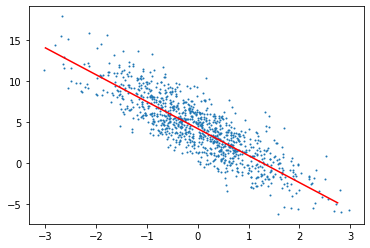

In [0]:
X = np.arange(-3, 3, 0.25)
 
def predict_plot(input_data, weight, bias):
  weight = weight.reshape(2, 1)
  input_data = np.array([np.zeros_like(input_data), input_data])
  input_data = input_data.transpose(1,0)
  y_hat = np.dot(input_data.reshape(-1,2), weight) + bias
  return y_hat

y_hat = predict_plot(X,weight, bias)

plt.scatter(features[:,1],labels, 1)
plt.plot(X, y_hat, color = 'r')
plt.show()

In [0]:
! git clone https://github.com/seonleeuni/mge51101-20205196.git

Cloning into 'mge51101-20205196'...
fatal: could not read Username for 'https://github.com': No such device or address
